Sources of code that i used for this project

https://colab.research.google.com/drive/1Hobi6plfrrUQ9DCiFPZ6vaztOu5Q05ND#scrollTo=vOOvIVeAlR1-

By Ramele Rodrigo (Artifical intelligence professor at Instituto Tecnologico de Buenos Aires)

https://keras.io/examples/generative/vae/

By François Chollet (Creator of Keras)

In [2]:
# Imports needed
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
import re
from scipy.stats import norm

In [22]:
# Variables to be used
image_h = 28
image_w = 28
number_of_channels = 1
image_size = image_h * image_w
epochs = 200
batch_size = 40
learning_rate = 0.001
stddev = 1.0
latent_dim = 2
intermediate_layer = 512
filters = 32
kernel_size = 4
strides = 1

In [23]:
# Sampling function
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), mean=0., stddev=stddev)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [24]:
# Encoder definition
encoder_inputs = keras.Input(shape=(image_h,image_w, number_of_channels))
x = layers.Conv2D(filters, kernel_size, activation="relu", strides=strides, padding="same")(encoder_inputs)
#x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(intermediate_layer, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   544         input_5[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 25088)        0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          12845568    flatten_2[0][0]                  
____________________________________________________________________________________________

In [25]:
# Decoder definition
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_layer, activation="relu")(latent_inputs)
x = layers.Dense(image_h * image_w * filters, activation="relu")(x)
x = layers.Reshape((image_h, image_w, filters))(x)    # Carefoul when stride > 1 you gotta divide it by stride
#x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(filters, kernel_size, activation="relu", strides=strides, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(number_of_channels, kernel_size, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_8 (Dense)              (None, 25088)             12870144  
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        16416     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         513       
Total params: 12,888,609
Trainable params: 12,888,609
Non-trainable params: 0
_______________________________________________

In [26]:
# VAE class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
          z_mean, z_log_var, z = self.encoder(data)
          reconstruction = self.decoder(z)
          reconstruction_loss = tf.reduce_mean(
              tf.reduce_sum(
                  keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
              )
          )
          kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
          kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
          total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [27]:
# Obtaining dataset and pre-processing
import glob
images = glob.glob('images/*.jpg')
imarray = list()
labels = list()
labels_dic = {'circle':0, 'diamond':1, 'hexagon':2, 'pentagon':3}
for f in images:
  # Read Image 
  m = re.search('/([a-zA-Z]+)', f)
  if m:
    ii = cv.imread(f)
    gray_image = cv.cvtColor(ii, cv.COLOR_BGR2GRAY)
    imarray.append(gray_image)
    labels.append(labels_dic[m.group(1)])
input = np.asarray(imarray)
labels = np.asarray(labels)
input = np.expand_dims(input, -1).astype("float32") / 255

In [28]:
# Training of VAE with dataset
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(input, epochs=epochs, shuffle=True, batch_size=batch_size)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 542.2364 - reconstruction_loss: 542.2323 - kl_loss: 0.0041
Epoch 2/200
1/1 [==============================] - 0s 422ms/step - loss: 503.0675 - reconstruction_loss: 484.9617 - kl_loss: 18.1058
Epoch 3/200
1/1 [==============================] - 0s 435ms/step - loss: 698.0023 - reconstruction_loss: 291.7253 - kl_loss: 406.2770
Epoch 4/200
1/1 [==============================] - 0s 442ms/step - loss: 397.2037 - reconstruction_loss: 371.7038 - kl_loss: 25.4999
Epoch 5/200
1/1 [==============================] - 0s 431ms/step - loss: 310.7203 - reconstruction_loss: 289.7585 - kl_loss: 20.9618
Epoch 6/200
1/1 [==============================] - 0s 421ms/step - loss: 293.8756 - reconstruction_loss: 267.0842 - kl_loss: 26.7914
Epoch 7/200
1/1 [==============================] - 0s 435ms/step - loss: 278.0013 - reconstruction_loss: 243.1337 - kl_loss: 34.8676
Epoch 8/200
1/1 [==============================] - 0s 426ms/step - loss:

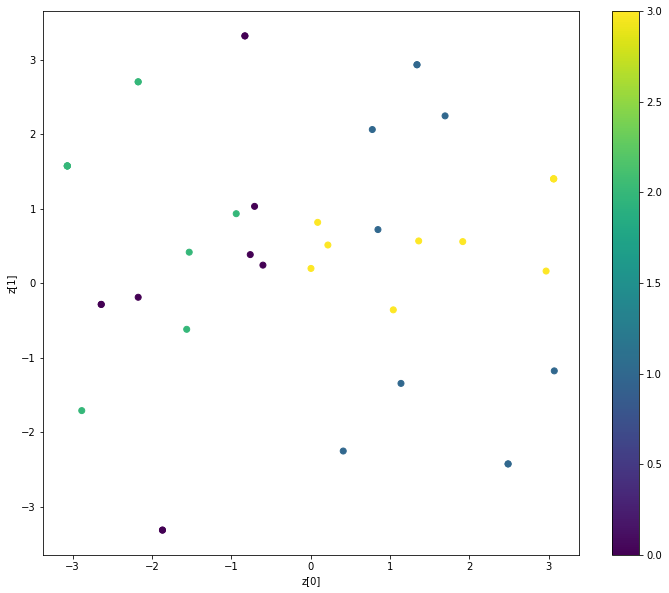

{'circle': 0, 'diamond': 1, 'hexagon': 2, 'pentagon': 3}


In [29]:
# Latent Layer (In progress)
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, input, labels)
print(labels_dic)

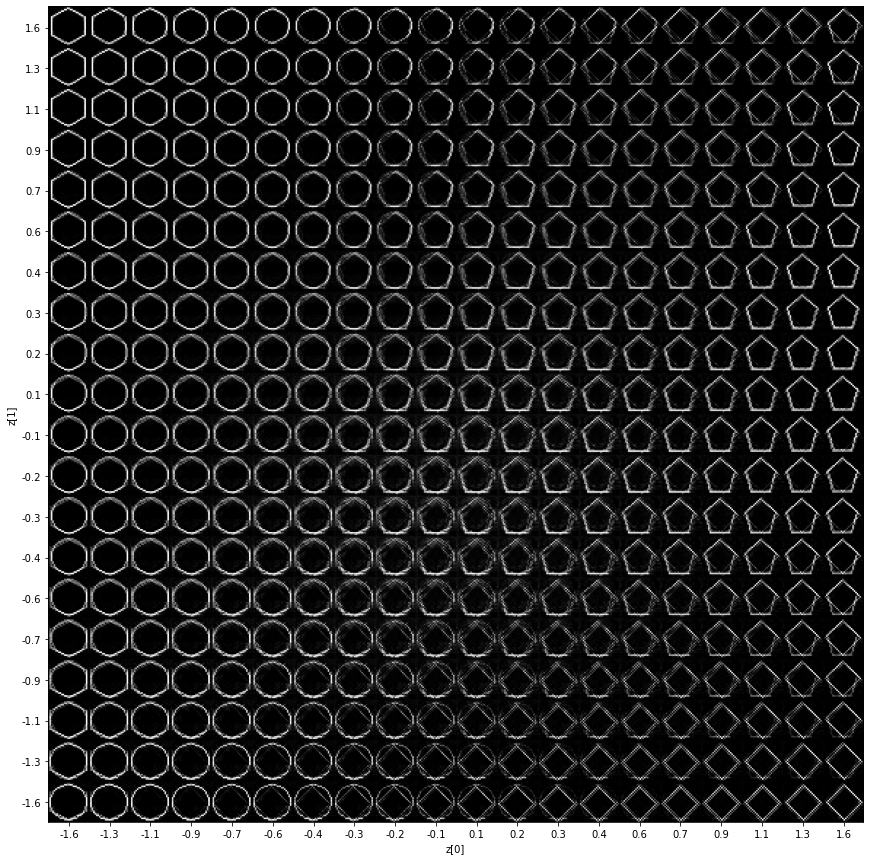

In [30]:
# Grid display
def plot_latent_space(vae, n=20, figsize=15):
    # display a n*n 2D manifold of shapes
    shape_size = image_h
    scale = 1.0
    figure = np.zeros((shape_size * n, shape_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of shape classes in the latent space
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            shape = x_decoded[0].reshape(shape_size, shape_size)
            figure[
                i * shape_size : (i + 1) * shape_size,
                j * shape_size : (j + 1) * shape_size,
            ] = shape

    plt.figure(figsize=(figsize, figsize))
    start_range = shape_size // 2
    end_range = n * shape_size + start_range
    pixel_range = np.arange(start_range, end_range, shape_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)